## Presentation 2: Sharon's code 

Modification of Alyssa's code from Fall quarter by

1. Not allowing square patches to overlap
2. Making square patches size multiple of 2
3. Making patches with only one label (benign/low-grade/high-grade) by using sample tissue manually annotated in Qu-Path
4. Ensure each patch is at least 50% epithelium and at most 90% epithelium (to ensure enough epithelium is covered but also that enough of width of epithelium is covered) - different from definition of "width" we discussed in class

In [21]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg

In [24]:
# Load the image
image_path0 = 'demo_labels/H1844192  h&e_ROI_1-original.tif' 
image0 = cv2.imread(image_path0)
image_path1 = 'demo_labels/H1844192  h&e_ROI_1-labels.tif' 
image1 = cv2.imread(image_path1)

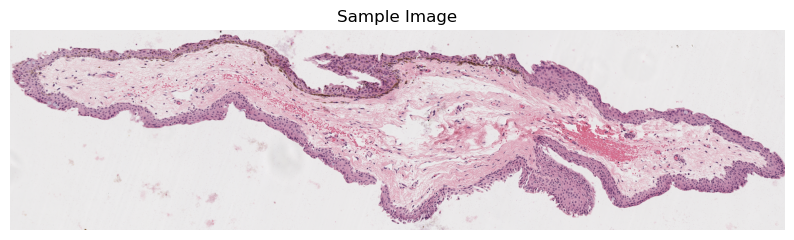

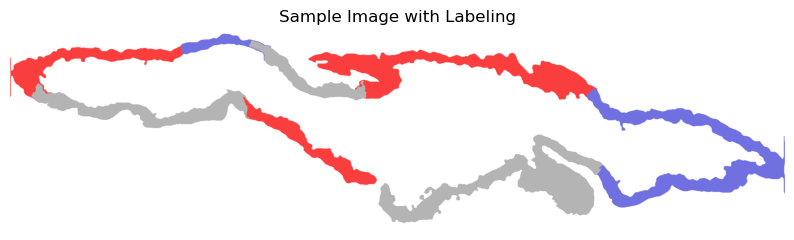

In [25]:
# Display sample image and labeling 
plt.figure(figsize=(10, 10))
plt.title("Sample Image")
plt.imshow(cv2.cvtColor(image0, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Display sample image and labeling 
plt.figure(figsize=(10, 10))
plt.title("Sample Image with Labeling")
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Placing patches of size 1024x1024 with at least 50% epithelium coverage
Placing patches of size 512x512 with at least 50% epithelium coverage
Placing patches of size 256x256 with at least 50% epithelium coverage


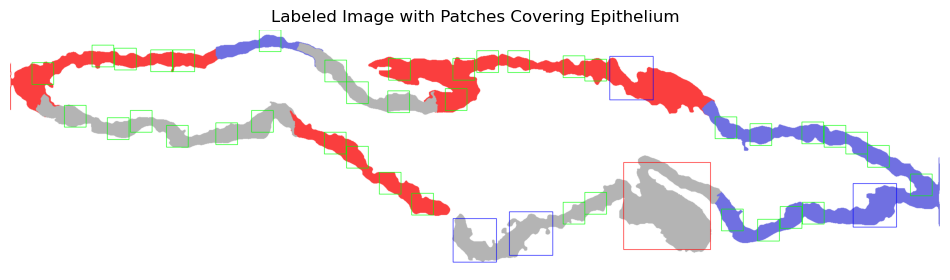

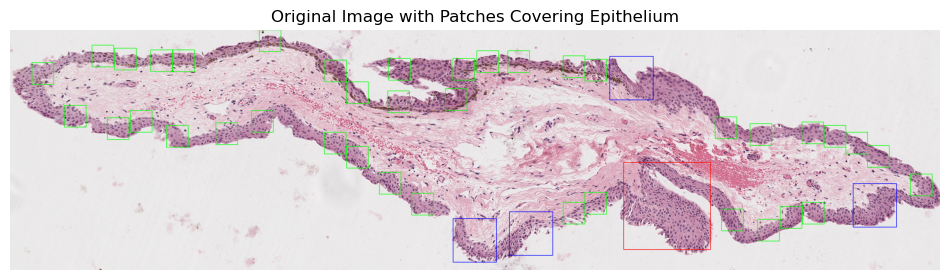

Number of patches of size 1024x1024: 1
Number of patches of size 512x512: 4
Number of patches of size 256x256: 39


In [40]:
# Mask for the epithelium (exclude black & white)
## Problem: The mask is not accurate, it excludes any color that has at least one 255 in its RGB value
epithelium_mask = cv2.inRange(image1, np.array([1, 1, 1]), np.array([254, 254, 254]))

# Patch sizes (from largest to smallest)
patch_sizes = [1024, 512, 256]

# Epithelium coverage thresholds for each patch size
epithelium_thresholds = {
    1024: 50,
    512: 50,
    256: 50
}

# Step sizes for the grids (no overlap for all patch sizes)
step_sizes = {size: size for size in patch_sizes}

# Initialize dictionaries to store patches of different sizes
patches = {size: [] for size in patch_sizes}
zoomed_in_regions = []
rect_dimensions = []
image_with_patches = image1.copy()
original_image_with_patches = image0.copy()

# Colors for different patch sizes (in BGR format)
patch_colors = {
    1024: (0, 0, 255),  # Yellow
    512: (255, 0, 0),    # Blue
    256: (0, 255, 0),    # Green
}

# Function to compute overlap percentage between two patches
def compute_overlap(patchA, patchB):
    # Determine the coordinates of the intersection rectangle
    x_left = max(patchA['left'], patchB['left'])
    y_top = max(patchA['top'], patchB['top'])
    x_right = min(patchA['right'], patchB['right'])
    y_bottom = min(patchA['bottom'], patchB['bottom'])

    if x_right <= x_left or y_bottom <= y_top:
        return 0.0  # No overlap

    # Compute the area of overlap
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Compute the area of both rectangles
    areaA = (patchA['right'] - patchA['left']) * (patchA['bottom'] - patchA['top'])
    areaB = (patchB['right'] - patchB['left']) * (patchB['bottom'] - patchB['top'])

    # Compute the overlap percentage relative to both patches
    overlap_percentage_A = (intersection_area / areaA) * 100
    overlap_percentage_B = (intersection_area / areaB) * 100

    # Return the maximum overlap percentage
    return max(overlap_percentage_A, overlap_percentage_B)

# Start from the top-left corner of the epithelium bounding patch
coords = cv2.findNonZero(epithelium_mask)
x, y, w, h = cv2.boundingRect(coords)
start_x = x
start_y = y
end_x = x + w
end_y = y + h

# Initialize the covered mask
covered_mask = np.zeros_like(epithelium_mask)

### Loop over patch sizes from largest to smallest ###
for size in patch_sizes:
    patch_list = patches[size]
    step_size = step_sizes[size]
    color = patch_colors[size]
    required_coverage = epithelium_thresholds[size]
    half_size = size // 2
    separation_threshold = 0.15 * size  # 15% of the patch width
    max_shift = half_size  # Maximum shift is half the patch size
    shift_step = 10  # Shift step in pixels
    print(f"Placing patches of size {size}x{size} with at least {required_coverage}% epithelium coverage")

    # Update the remaining epithelium mask
    remaining_epithelium_mask = cv2.bitwise_and(epithelium_mask, cv2.bitwise_not(covered_mask))

    for top in range(start_y, end_y, step_size):
        for left in range(start_x, end_x, step_size):
            best_coverage = 0
            best_shifted_left = None
            best_shifted_top = None

            # Define shift ranges
            shift_range = range(-max_shift, max_shift + 1, shift_step)

            # Search for the shift that captures at least two separate black/white areas in different regions
            for shift_x in shift_range:
                for shift_y in shift_range:
                    shifted_left = left + shift_x
                    shifted_top = top + shift_y
                    shifted_right = shifted_left + size
                    shifted_bottom = shifted_top + size

                    # Ensure coordinates are within image bounds
                    if shifted_top < 0 or shifted_left < 0 or shifted_bottom > image1.shape[0] or shifted_right > image1.shape[1]:
                        continue  # Skip positions that go beyond image boundaries

                    # Extract the patch region
                    patch_region = image1[shifted_top:shifted_bottom, shifted_left:shifted_right]
                    patch_mask = remaining_epithelium_mask[shifted_top:shifted_bottom, shifted_left:shifted_right]

                    # Calculate the percentage of epithelium pixels in the patch
                    total_pixels = patch_mask.size  # Total number of pixels in the patch
                    epithelium_pixels = cv2.countNonZero(patch_mask)
                    epithelium_percentage = (epithelium_pixels / total_pixels) * 100

                    # Proceed only if epithelium coverage meets the required threshold
                    # and is less than 90% (to avoid not enough of entire epithelium width covered)
                    if epithelium_percentage >= required_coverage and epithelium_percentage < 90:
                        # Create a binary mask for black regions within the patch
                        black_region_mask = cv2.bitwise_not(patch_mask)

                        # Perform connected component analysis on the black regions
                        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(black_region_mask)

                        # Subtract one from num_labels to exclude the background label (0)
                        num_black_regions = num_labels - 1

                        # Proceed only if there are at least two separate black regions
                        if num_black_regions >= 2:
                            # Extract areas of black regions
                            black_areas = [stats[label, cv2.CC_STAT_AREA] for label in range(1, num_labels)]
                            total_black_area = sum(black_areas)

                            # Check that no single black region accounts for more than 70% of total black area
                            largest_black_region_area = max(black_areas)
                            if largest_black_region_area <= 0.7 * total_black_area:
                                # Sort black regions by area
                                sorted_indices = np.argsort(-np.array(black_areas))

                                # Proceed to check the regions where these black regions are mostly located
                                black_region_labels = [sorted_indices[0] + 1, sorted_indices[1] + 1]
                                black_region_regions = []

                                # Define the four regions within the patch
                                height, width = black_region_mask.shape
                                half_height = height // 2
                                half_width = width // 2

                                # Create masks for the four regions
                                top_region_mask = np.zeros_like(black_region_mask, dtype=np.uint8)
                                top_region_mask[0:half_height, :] = 1

                                bottom_region_mask = np.zeros_like(black_region_mask, dtype=np.uint8)
                                bottom_region_mask[half_height:, :] = 1

                                left_region_mask = np.zeros_like(black_region_mask, dtype=np.uint8)
                                left_region_mask[:, 0:half_width] = 1

                                right_region_mask = np.zeros_like(black_region_mask, dtype=np.uint8)
                                right_region_mask[:, half_width:] = 1

                                for label in black_region_labels:
                                    region_mask = (labels == label).astype(np.uint8)

                                    # Calculate overlap with each region
                                    top_overlap = cv2.countNonZero(cv2.bitwise_and(region_mask, top_region_mask))
                                    bottom_overlap = cv2.countNonZero(cv2.bitwise_and(region_mask, bottom_region_mask))
                                    left_overlap = cv2.countNonZero(cv2.bitwise_and(region_mask, left_region_mask))
                                    right_overlap = cv2.countNonZero(cv2.bitwise_and(region_mask, right_region_mask))

                                    # Determine which region has the maximum overlap
                                    overlaps = {
                                        'top': top_overlap,
                                        'bottom': bottom_overlap,
                                        'left': left_overlap,
                                        'right': right_overlap
                                    }
                                    max_region = max(overlaps, key=overlaps.get)
                                    black_region_regions.append(max_region)

                                # Check if the two largest black regions are mostly in different regions
                                if black_region_regions[0] != black_region_regions[1]:
                                    # Update best coverage and position
                                    if epithelium_percentage > best_coverage:
                                        best_coverage = epithelium_percentage
                                        best_shifted_left = shifted_left
                                        best_shifted_top = shifted_top
                                        best_patch_region = patch_region
                                        best_patch_mask = patch_mask
                                        best_epithelium_pixels = epithelium_pixels
                                        best_black_areas = black_areas  # Save black areas for later use
                                        best_total_black_area = total_black_area
                                        best_largest_black_region_area = largest_black_region_area

            # After searching all shifts, proceed with the best position
            if best_coverage >= required_coverage and best_shifted_left is not None:
                # Ensure the largest black region does not exceed 70% of total black area
                if best_largest_black_region_area <= 0.7 * best_total_black_area:
                    # Create a dictionary for the current patch
                    current_patch = {'left': best_shifted_left, 'top': best_shifted_top, 'right': best_shifted_left + size, 'bottom': best_shifted_top + size}

                    # Check for more than one label in the patch
                    patch_region = image1[best_shifted_top:best_shifted_top+size, best_shifted_left:best_shifted_left+size]

                    # Check if there is more than one color in the patch
                    non_unique_label = False
                    unique_colors = np.unique(patch_region.reshape(-1, patch_region.shape[2]), axis=0)
                    if len(unique_colors) > 2:
                        non_unique_label = True
                    
                    # Check for overlap with existing patches of all sizes
                    overlap_found = False
                    for other_size in patch_sizes:
                        # Skip if there are no patches of this size yet
                        if not patches[other_size]:
                            continue
                        for existing_patch in patches[other_size]:
                            overlap_percentage = compute_overlap(current_patch, existing_patch)
                            # Do not draw patch if there is any overlap
                            if overlap_percentage > 0:
                                overlap_found = True
                                break  # No need to check further
                        if overlap_found:
                            break  # No need to check other sizes

                    if not (overlap_found or non_unique_label):
                        # Store the patch information
                        patch_list.append(current_patch)
                        zoomed_in_regions.append(best_patch_region)
                        rect_dimensions.append((size, size))

                        # Draw the patch on the image
                        thickness = 6
                        cv2.rectangle(image_with_patches, (best_shifted_left, best_shifted_top), (best_shifted_left + size, best_shifted_top + size), color, thickness=thickness)
                        cv2.rectangle(original_image_with_patches, (best_shifted_left, best_shifted_top), (best_shifted_left + size, best_shifted_top + size), color, thickness=thickness)
                    else:
                        # Skip this patch due to overlap
                        continue
                else:
                    # Largest black region exceeds 70% of total black area; skip this patch
                    continue

# Display the labelled image with all patches
plt.figure(figsize=(12, 12))
plt.title("Labeled Image with Patches Covering Epithelium")
plt.imshow(cv2.cvtColor(image_with_patches, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Display the original image with all patches
plt.figure(figsize=(12, 12))
plt.title("Original Image with Patches Covering Epithelium")
plt.imshow(cv2.cvtColor(original_image_with_patches, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Print number of patches of each size
for size in patch_sizes:
    print(f"Number of patches of size {size}x{size}: {len(patches[size])}")